In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

## Dataset preparation

### Set parameters

In [1]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "/drive0-storage/Gracia/dataset_3/training"
val_path = "/drive0-storage/Gracia/dataset_3/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

Found 16332 files belonging to 3 classes.
Using 13066 files for training.
Found 4080 files belonging to 3 classes.
Using 816 files for validation.


In [ ]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [8]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 239.0
(184, 216, 3)


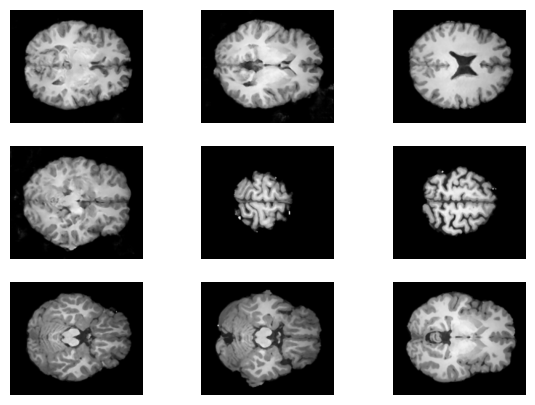

In [7]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [6]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)

In [7]:
# Buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE

with tf.device("CPU"):
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [8]:
for images in train_ds.take(1):
    img = images[0]
    print(img.shape)  
    print(img.dtype)  
    print(np.min(img),np.max(img))  

(8, 184, 216, 3)
<dtype: 'float32'>
0.0 246.1778


In [9]:
len(validation_dataset)

268

## Model building

In [10]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [11]:
with tf.device("GPU"):
    vgg16 = build_vgg16()

    # add rescale layer, chain model
    rescale = tf.keras.layers.Rescaling(1./255)
    inputs = tf.keras.Input(shape = img_shape)
    x = rescale(inputs)
    outputs = vgg16(x)
    model = tf.keras.Model(inputs,outputs) 
    
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [12]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.98):
            print("\nReached 98% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()

save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
EPOCH = 50

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            callbacks=[checkpoints_cb, early_stopping, callbacks])

In [ ]:
EPOCH = 20

history_no_callback = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH)

### Training evaluation

In [ ]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')


plt.subplots_adjust(hspace=0.3)
plt.show()

## Testing

In [ ]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, 
            annot=True)
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.show()